<a href="https://colab.research.google.com/github/rksab/NLP/blob/main/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


# Word Vectors
Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from co-occurrence matrices, and those derived via GloVe.

**Note on Terminology**: The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As Wikipedia states, "conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension".

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a read_corpus function below that pulls out only articles from the "gold" (i.e. news articles about gold, mining, etc.) category. The function also adds START and END tokens to each of the documents, and lowercases words. You do not have to perform any other kind of pre-processing.

In [ ]:
def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

Let's have a look what these documents are like….

In [ ]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western',
  'mining', 'corp', 'holdings', 'ltd', '&', 'lt', ';', 'wmng', '.', 's', '>', '(', 'wmc', ')',
  'said', 'it', 'will', 'establish', 'a', 'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the',
  'northern', 'territory', 'at', 'a', 'cost', 'of', 'about', '21', 'mln', 'dlrs', '.', 'the',
  'mine', ',', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', ',', 'will', 'be', 'owned',
  '60', 'pct', 'by', 'wmc', 'and', '40', 'pct', 'by', 'a', 'local', 'w', '.', 'r', '.', 'grace',
  'and', 'co', '&', 'lt', ';', 'gra', '>', 'unit', '.', 'it', 'is', 'located', '30', 'kms', 'east',
  'of', 'the', 'adelaide', 'river', 'at', 'mt', '.', 'bundey', ',', 'wmc', 'said', 'in', 'a',
  'statement', 'it', 'said', 'the', 'open', '-', 'pit', 'mine', ',', 'with', 'a', 'conventional',
  'leach', 'treatment', 'plant', ',', 'is', 'expected', 'to', 'produce', 'about', '50', ',', '000',
  'ounces', 'of', 'gold'

Question 1.1: Implement distinct_words [code] (2 points)
Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, this may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's more information.

Your returned corpus_words should be sorted. You can use python's sorted function for this.

You may find it useful to use Python sets to remove duplicate words.

In [ ]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    ### SOLUTION BEGIN. Using the hint given in the assignment. 
    new_corpus = [y for x in corpus for y in x]
    #Sorted distinct words
    corpus_words = sorted(set(new_corpus))
    # total number of ditinct words. 
    n_corpus_words = len(corpus_words)
    
    ### SOLUTION END

    return corpus_words, n_corpus_words

In [ ]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Question 1.2: Implement compute_co_occurrence_matrix [code] (3 points)
Write a method that constructs a co-occurrence matrix for a certain window-size 
n (with a default of 4), considering words n
 before and n after the word in the center of the window. Here, we start to use numpy (np) to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n Python NumPy tutorial.

In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    # Initialise a matrix of zeroes of the size of M. 
    M = np.zeros((n_words, n_words))
    # Creating a dictionary to map distinct words to index
    word2ind = {val: idx for idx, val in enumerate(words)}
    
    ### SOLUTION BEGIN
    for sentence in corpus:
      for w in range(len(sentence)):
        current_word = sentence[w]
        neighbours = sentence[max(0,w-window_size): min(w+window_size+1, len(sentence))]
        for n in neighbours:
           M[word2ind[current_word],word2ind[n]] += 1
        M[word2ind[current_word],word2ind[current_word]] -= 1




            
    ### SOLUTION END

    return M, word2ind


In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Question 1.3: Implement reduce_to_k_dim [code] (1 point)
Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use sklearn.decomposition.TruncatedSVD.

In [ ]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = np.zeros((M.shape[0], k))
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    ### SOLUTION BEGIN
    svd = TruncatedSVD(n_components = k, n_iter = n_iters) 
    svd.fit(M)
    M_reduced = svd.transform(M)
    ### SOLUTION END

    print("Done.")
    return M_reduced

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Question 1.4: Implement plot_embeddings [code] (1 point)
Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).

For this example, you may find it useful to adapt this code. In the future, a good way to make a plot is to look at the Matplotlib gallery, find a plot that looks somewhat like what you want, and adapt the code they give.

In [ ]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    ### SOLUTION BEGIN
    for i,word in enumerate(words):
      x = M_reduced[i,0]
      y = M_reduced[i,1]
      plt.scatter(x, y, marker='x', color='red')
      plt.text(x+0.003, y+0.003, word, fontsize=9)
    plt.show()
    ### SOLUTION END


--------------------------------------------------------------------------------
Outputted Plot:


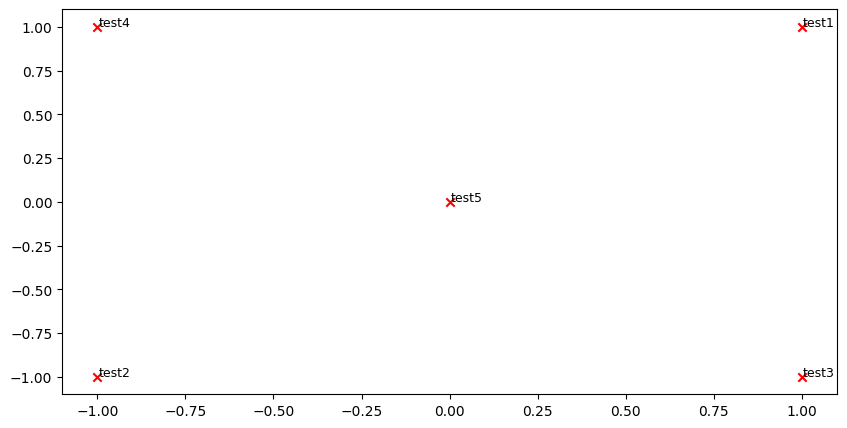

--------------------------------------------------------------------------------


In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

# Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)
Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "gold" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). Note: The line of code below that does the normalizing uses the NumPy concept of broadcasting. If you don't know about broadcasting, check out Computation on Arrays: Broadcasting by Jake VanderPlas.

Run the below cell to produce the plot. It'll probably take a few seconds to run.

Running Truncated SVD over 2830 words...
Done.


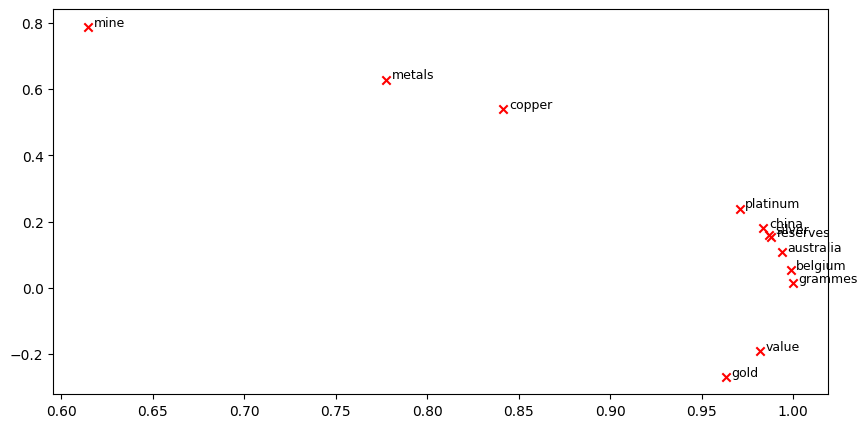

In [ ]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

a. Find at least two groups of words that cluster together in 2-dimensional embedding space. Give an explanation for each cluster you observe.

SOLUTION BEGIN
Clusters together locations, and metals to some extent: gold, silver and platinum are kinda close. It understands locations and metals. 
SOLUTION END
b. What doesn't cluster together that you might think should have? Describe at least two examples.

SOLUTION BEGIN
Mine is at the top corner, doesn't understand that metals are mined. Clumps together names These words often appear together. It captures together locations and fails to show their relationship to metals. 
SOLUTION END

# Part 2: Prediction-Based Word Vectors (15 points)
As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading GloVe's original paper.

Then run the following cells to load the GloVe vectors into memory. Note: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [ ]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


# Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead. Run the following cells to:

Put 10000 Glove vectors into a matrix M
Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting


Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


Question 2.1: GloVe Plot Analysis [written] (3 points)
Run the cell below to plot the 2D GloVe embeddings for ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"].

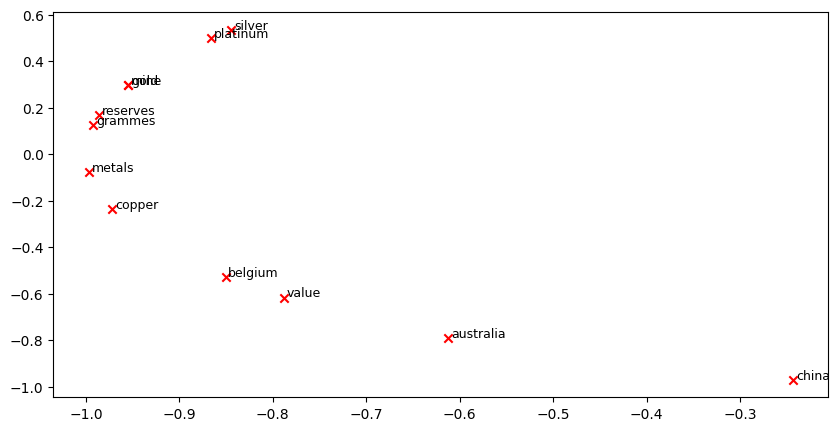

In [ ]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_reduced_normalized, word2ind, words)

a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

SOLUTION BEGIN: 
Locations are more spread out and it's more clear that we are prolly talking about countries where metals are mined. Metals are close. 
SOLUTION END
b. What is a possible cause for the difference?
SOLUTION BEGIN
SOLUTION END

# Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this wiki page to learn more about the difference between polysemes and homonyms ). Find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words)?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the GenSim documentation.



In [ ]:
poly = ['leaf', 'plant', 'man', 'woman', 'book', 'novel', 'magnet', 'country', 'song']

for word in poly:
  print('possible polysemes for ' + word +':')
  print(wv_from_bin.most_similar(word))
  print('.'*15)

possible polysemes for leaf:
[('leaves', 0.6027015447616577), ('maple', 0.5392975211143494), ('axils', 0.5315778851509094), ('buds', 0.5083805322647095), ('flower', 0.5031899809837341), ('foliage', 0.49968624114990234), ('stalk', 0.48566144704818726), ('bark', 0.485382616519928), ('flowers', 0.48411503434181213), ('purple', 0.4813902974128723)]
...............
possible polysemes for plant:
[('plants', 0.8802077174186707), ('factory', 0.6054627299308777), ('facility', 0.556488573551178), ('produce', 0.5439175367355347), ('production', 0.5205835103988647), ('chemical', 0.5185851454734802), ('producing', 0.5161451101303101), ('waste', 0.5101147890090942), ('factories', 0.506610631942749), ('flowering', 0.5009768009185791)]
...............
possible polysemes for man:
[('woman', 0.7520086765289307), ('person', 0.6917079091072083), ('another', 0.6866576075553894), ('boy', 0.6848181486129761), ('one', 0.6820703744888306), ('who', 0.6693941354751587), ('he', 0.6683939099311829), ('himself', 0.

Polysemous words discovered: plant. Didn't work for other words. For example, book is a noun as well as a verb but too often is used as a noun and the data it was trained on reflects that. When it comes to plant, it seems the data has documents related to chemical plants etc as well. Magnetic field related documents are missing prolly and hence it understands only one meaning: attract. 

Question 2.3: Synonyms & Antonyms (2 points) [code + written]
When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.

In [ ]:
### SOLUTION BEGIN

w1 = "novel"
w2 = "new"
w3 = "old"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)
w2_w3_dist = wv_from_bin.distance(w2, w3)
w2_w1_dist = wv_from_bin.distance(w2, w1)


print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w2, w3, w2_w3_dist))
print("Synonyms {}, {} have cosine distance: {}".format(w2, w1, w2_w1_dist))

### SOLUTION END

Synonyms novel, new have cosine distance: 0.6577989459037781
Antonyms novel, old have cosine distance: 0.7857635468244553
Antonyms new, old have cosine distance: 0.5118605494499207
Synonyms new, novel have cosine distance: 0.6577989459037781


New is closer to old than it is to novel. New and old are related to time and are on opposite ends and hence in that sense closer in indicating degree. 

Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to sometimes exhibit the ability to solve analogies.

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the most_similar function from the GenSim documentation. The function finds words that are most similar to the words in the positive list and most dissimilar from the words in the negative list (while omitting the input words, which are often the most similar; see this paper). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [ ]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]




Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would man and woman lie in the coordinate plane relative to grandfather and the answer?

Woman-man = Grandmother - grandfather 

Familial relationships?

In [ ]:
### SOLUTION BEGIN

pprint.pprint(wv_from_bin.most_similar(positive=['bad', 'excellent'], negative=['good']))

### SOLUTION END

[('mediocre', 0.5432418584823608),
 ('quality', 0.5288185477256775),
 ('performance', 0.5142474174499512),
 ('superb', 0.5098724365234375),
 ('lousy', 0.49959325790405273),
 ('poor', 0.4916036128997803),
 ('exceptional', 0.4892101287841797),
 ('exceptionally', 0.4821390211582184),
 ('terrific', 0.48156294226646423),
 ('extremely', 0.4633115530014038)]


In [ ]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


In [ ]:
### SOLUTION BEGIN

A = "black"
B = "asian"
word = "terrorism"
pprint.pprint(wv_from_bin.most_similar(positive=[A, word], negative=[B]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[B, word], negative=[A]))

### SOLUTION END

[('crime', 0.5132246613502502),
 ('white', 0.5037162899971008),
 ('terrorists', 0.4900360405445099),
 ('terror', 0.48979172110557556),
 ('hate', 0.4803518056869507),
 ('criminal', 0.47853681445121765),
 ('extremism', 0.47816410660743713),
 ('terrorist', 0.4757554531097412),
 ('wearing', 0.45796993374824524),
 ('violence', 0.44157975912094116)]

[('terror', 0.6010050773620605),
 ('asia', 0.5989146828651428),
 ('terrorist', 0.5759069919586182),
 ('combating', 0.5344136357307434),
 ('asean', 0.5093969702720642),
 ('terrorists', 0.4974301755428314),
 ('cooperation', 0.4927140772342682),
 ('countries', 0.48917436599731445),
 ('global', 0.4790569841861725),
 ('pakistan', 0.4747745096683502)]
